In [ ]:
'''
Use the noise-to-noise to get the estimation of the noise
'''

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
import sys
import SimpleITK as sitk
import glob
import scipy.optimize
import scipy.ndimage
import skimage.metrics 

In [3]:
sys.path.append('..')
import CTProjector.projector.ct_projector as ct_projector
import model.unet as unet

In [4]:
import argparse
import configparser
parser = argparse.ArgumentParser()
parser.add_argument('--prj_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo_2d_3_layer_mean/prj_quarter/')
parser.add_argument('--ref_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo_2d_3_layer_mean/prj_full/')
parser.add_argument('--name', default = 'L143')
parser.add_argument('--geometry', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo/geometry.cfg')
parser.add_argument('--islices', type = int, nargs = 2, default = [60,61])
parser.add_argument('--N0', type = float, default = 2e5)
parser.add_argument('--dose_rate', type=float, default = 16)

parser.add_argument('--device', type = int, default = 0)
parser.add_argument('--img_norm', type = float, default = 0.019)
parser.add_argument('--train_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/')
parser.add_argument('--checkpoint', type=int, default = 50)
parser.add_argument('--tags', default = None)

parser.add_argument('--vmin', type=float, default = -0.16)
parser.add_argument('--vmax', type=float, default = 0.24)
parser.add_argument('--N0_ref', type=float, default = 4e5)
parser.add_argument('--filter', default = 'hann')

if sys.argv[0] != 'noise2noise_ensemble.py':
    showplot = True
    args = parser.parse_args(['--device', '0', 
                              '--name', 'L143',
                              '--N0', '-1',
                              '--dose_rate','4',
                              '--islices', '50','51',
#                               '--filter', 'ramp',
#                               '--vmin', '-1.35',
#                               '--vmax', '0.15',
#                               '--tags', 'l2_depth_3_window/dose_rate_2,l2_depth_3_window/dose_rate_4,l2_depth_3_window/dose_rate_8',
                              '--tags', 'l2_depth_3/dose_rate_2,l2_depth_3/dose_rate_4,l2_depth_3/dose_rate_8,l2_depth_3/dose_rate_16,l2_depth_3/all',
                              '--checkpoint', '50',
                              
#                               '--tags', 'L067,L096,L109,L192,L310,L286,all',
                             ])
else:
    showplot = False
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', getattr(args, k))

prj_dir = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo_2d_3_layer_mean/prj_quarter/
ref_dir = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo_2d_3_layer_mean/prj_full/
name = L143
geometry = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo/geometry.cfg
islices = [50, 51]
N0 = -1.0
dose_rate = 4.0
device = 0
img_norm = 0.019
train_dir = /home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/
checkpoint = 50
tags = l2_depth_3/dose_rate_2,l2_depth_3/dose_rate_4,l2_depth_3/dose_rate_8,l2_depth_3/dose_rate_16,l2_depth_3/all
vmin = -0.16
vmax = 0.24
N0_ref = 400000.0
filter = hann


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '%d'%args.device
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
# first load data and do reconstruction
projector = ct_projector.ct_projector()
projector.from_file(args.geometry)
projector.nv = 1
for k in vars(projector):
    print (k, '=', getattr(projector, k))
angles = projector.get_angles()

nview = 2304
nu = 736
nv = 1
nx = 640
ny = 640
nz = 1
dx = 0.75
dy = 0.75
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x2aac75514580>


In [7]:
sitk_prjs = sitk.ReadImage(os.path.join(args.ref_dir, args.name + '.nii'))
prj = sitk.GetArrayFromImage(sitk_prjs)[args.islices[0]:args.islices[1]] / args.img_norm
prj = prj[:, :, np.newaxis, :] # insert the v dimension

# reconstruct full dose image
fprj = projector.ramp_filter(prj, args.filter)
ref = projector.fbp_fan_bp(fprj, angles) - 1

# noise insertion
np.random.seed(0)
if args.N0 > 0:
    prj = prj + np.sqrt((1 - 1 / args.dose_rate) * args.dose_rate * np.exp(prj * args.img_norm) / args.N0) * np.random.normal(size = prj.shape) / args.img_norm
    prj = prj.astype(np.float32)
else:
    sitk_prjs = sitk.ReadImage(os.path.join(args.prj_dir, args.name + '.nii'))
    prj = sitk.GetArrayFromImage(sitk_prjs)[args.islices[0]:args.islices[1]] / args.img_norm
    prj = prj[:, :, np.newaxis, :] # insert the v dimension

In [8]:
# random splitting
inds_offset = np.random.randint(0, 2, prj.shape[1]//2)
inds1 = np.arange(0, prj.shape[1], 2) + inds_offset
inds2 = np.arange(0, prj.shape[1], 2) + (1 - inds_offset)
fprj = projector.ramp_filter(prj, args.filter)
img1 = projector.fbp_fan_bp(np.copy(fprj[:, inds1, ...], 'C'), angles[inds1]) * 2
img2 = projector.fbp_fan_bp(np.copy(fprj[:, inds2, ...], 'C'), angles[inds2]) * 2
img = np.array([img1, img2]) - 1
noise_approx = (img1 - img2) / 2

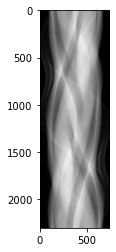

In [9]:
plt.imshow(prj.squeeze(), 'gray')

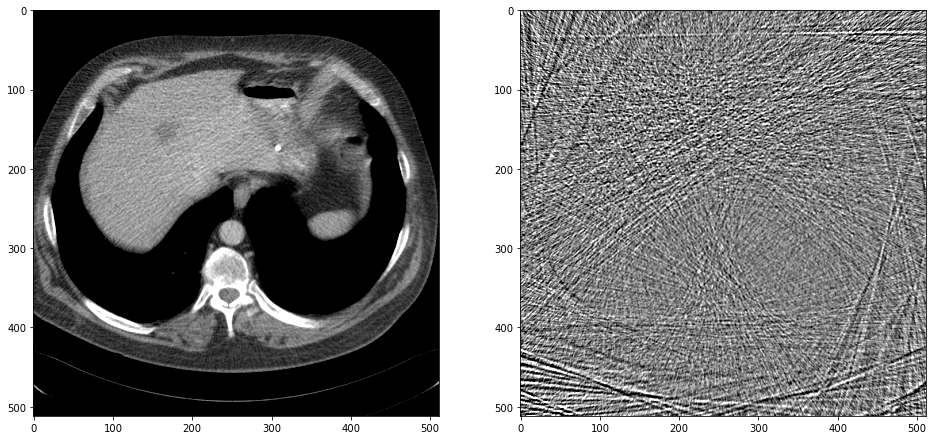

In [10]:
if showplot:
    plt.figure(figsize=[16,8])
    plt.subplot(121); plt.imshow(img.mean(0)[0,0,64:-64,64:-64], 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(122); plt.imshow(noise_approx[0,0,64:-64,64:-64], 'gray', vmin=-0.05, vmax=0.05)

In [11]:
K.clear_session()
# predict using the corresponding dose rate and the all dose rate
print ('Matched network', end=',')
dose_rate = int(args.dose_rate)
if dose_rate < 2:
    dose_rate = 2
elif dose_rate > 16:
    dose_rate = 16
checkpoint = os.path.join(args.train_dir, 'l2_depth_3/dose_rate_%d'%dose_rate, '50.h5')
model = tf.keras.models.load_model(checkpoint)
pred_matched = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[..., 0]
pred_matched = pred_matched[:, np.newaxis, :, :]

print ('Universal network', end=',')
checkpoint = os.path.join(args.train_dir, 'l2_depth_3/all/4.h5')
# checkpoint = os.path.join(args.train_dir, 'dose_rate_4/50.h5')
model = tf.keras.models.load_model(checkpoint)
pred_universal = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[..., 0]
pred_universal = pred_universal[:, np.newaxis, :, :]

# pred_universal = np.copy(ref)

Matched network,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Universal network,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


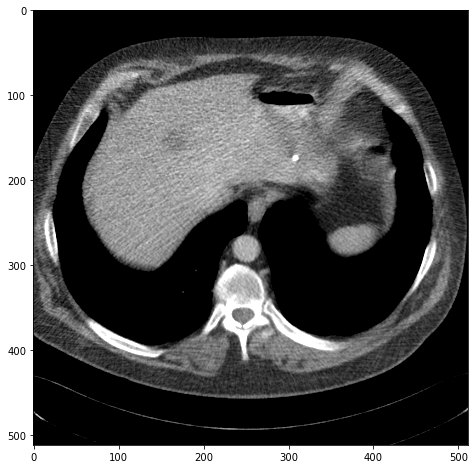

In [12]:
img_approx = pred_universal + noise_approx
# img_approx = img.mean(0) + (img.mean(0) - pred_universal)

plt.figure(figsize=[8,8])
plt.imshow(img_approx[0,0,64:-64,64:-64], 'gray', vmin=args.vmin, vmax=args.vmax)

In [13]:
# apply window function
def apply_window(x, vmin=-0.16, vmax=0.24):
    x = (x - vmin) / (vmax - vmin) * 2 - 1
    x[x < -1] = -1
    x[x > 1] = 1
    
    return x

def reverse_window(x, vmin=-0.16, vmax=0.24):
    return (x + 1) / 2 * (vmax - vmin) + vmin

In [14]:
# load models and generate denoising results
# list model directories
if args.tags is None:
    tags = [os.path.basename(s) for s in glob.glob(os.path.join(args.train_dir, 'l2_depth_3/dose_rate_*'))]
else:
    tags = args.tags.split(',')
# the list of denoised images
est_imgs = [img_approx]
# est_imgs = [ref + (1-noise_ratio) * noise_approx]
base_imgs = [img.mean(0)]
print ('Predicting:', end=' ', flush=True)
for i, tag in enumerate(tags):
    print (i, end=',', flush=True)
    if 'all' in tag:
        checkpoint = os.path.join(args.train_dir, tag, '4.h5')
    else:
        checkpoint = os.path.join(args.train_dir, tag, '%d.h5'%args.checkpoint)
    model = tf.keras.models.load_model(checkpoint)
    
    if 'window' in tag:
        est_input = apply_window(img_approx[:, 0, :, :, np.newaxis])
        img_input = apply_window(img.mean(0)[:, 0, :, :, np.newaxis])
    else:
        est_input = np.copy(img_approx[:, 0, :, :, np.newaxis])
        img_input = np.copy(img.mean(0)[:, 0, :, :, np.newaxis])
    
    pred_est = model.predict(est_input)[...,0]
#     pred_est = model.predict((ref + (1-noise_ratio) * noise_approx)[:, 0, :, :, np.newaxis])[...,0]
    pred = model.predict(img_input)[...,0]
    
    pred_est = pred_est[:, np.newaxis, :, :]
    pred = pred[:, np.newaxis, :, :]
    
    if 'window' in tag:
        pred_est = reverse_window(pred_est)
        pred = reverse_window(pred)
    
    est_imgs.append(pred_est)
    base_imgs.append(pred)
est_imgs = np.array(est_imgs)
base_imgs = np.array(base_imgs)

Predicting: 0,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
1,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
2,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
3,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
4,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [15]:
'''
# recurrent denoising
est_imgs = [img_approx]
# est_imgs = [ref + (1-noise_ratio) * noise_approx]
base_imgs = [img.mean(0)]
n_iter = 6
checkpoint = os.path.join(args.train_dir, 'dose_rate_2', '%d.h5'%args.checkpoint)
model = tf.keras.models.load_model(checkpoint)

print ('Predicting:', end=' ', flush=True)
for i in range(n_iter):
    print (i, end=',', flush=True)
    
    pred_est = model.predict(est_imgs[-1][:, 0, :, :, np.newaxis])[...,0]
#     pred_est = model.predict((ref + (1-noise_ratio) * noise_approx)[:, 0, :, :, np.newaxis])[...,0]
    pred = model.predict(base_imgs[-1][:, 0, :, :, np.newaxis])[...,0]
    
    pred_est = pred_est[:, np.newaxis, :, :]
    pred = pred[:, np.newaxis, :, :]
    
    est_imgs.append(pred_est)
    base_imgs.append(pred)
est_imgs = np.array(est_imgs)
base_imgs = np.array(base_imgs)
'''

"\n# recurrent denoising\nest_imgs = [img_approx]\n# est_imgs = [ref + (1-noise_ratio) * noise_approx]\nbase_imgs = [img.mean(0)]\nn_iter = 6\ncheckpoint = os.path.join(args.train_dir, 'dose_rate_2', '%d.h5'%args.checkpoint)\nmodel = tf.keras.models.load_model(checkpoint)\n\nprint ('Predicting:', end=' ', flush=True)\nfor i in range(n_iter):\n    print (i, end=',', flush=True)\n    \n    pred_est = model.predict(est_imgs[-1][:, 0, :, :, np.newaxis])[...,0]\n#     pred_est = model.predict((ref + (1-noise_ratio) * noise_approx)[:, 0, :, :, np.newaxis])[...,0]\n    pred = model.predict(base_imgs[-1][:, 0, :, :, np.newaxis])[...,0]\n    \n    pred_est = pred_est[:, np.newaxis, :, :]\n    pred = pred[:, np.newaxis, :, :]\n    \n    est_imgs.append(pred_est)\n    base_imgs.append(pred)\nest_imgs = np.array(est_imgs)\nbase_imgs = np.array(base_imgs)\n"

['l2_depth_3/dose_rate_2', 'l2_depth_3/dose_rate_4', 'l2_depth_3/dose_rate_8', 'l2_depth_3/dose_rate_16', 'l2_depth_3/all']


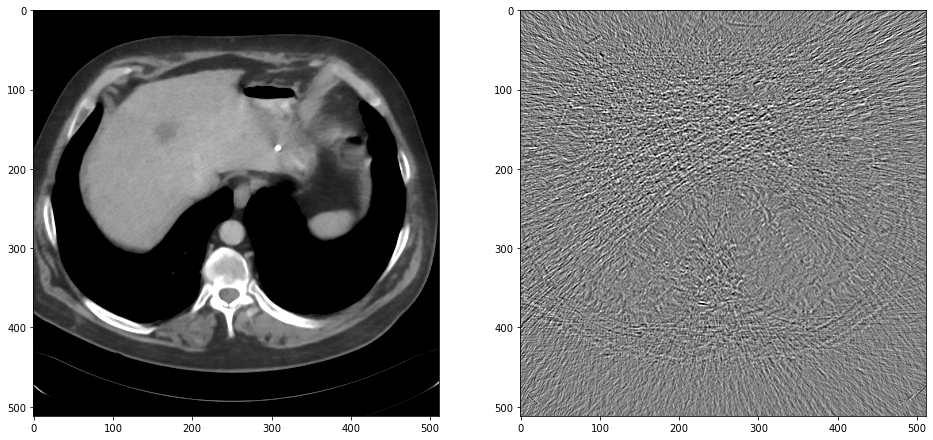

In [16]:
print (tags)
if showplot:
    plt.figure(figsize=[16,8])
    plt.subplot(121); plt.imshow(pred_universal[0,0,64:-64,64:-64], 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(122); plt.imshow((img.mean(0) - pred_universal)[0,0,64:-64,64:-64], 'gray', vmin=-0.05,vmax=0.05)

In [17]:
# # estimate noise level of reference image
fp = projector.siddon_fan_fp(pred_universal + 1, angles)
recon_noiseless = projector.fbp_fan_bp(projector.ramp_filter(fp, args.filter), angles)-1

fp_noisy = -np.log(np.random.poisson(args.N0_ref * np.exp(-fp * args.img_norm)) / args.N0_ref) / args.img_norm
recon_noisy = projector.fbp_fan_bp(projector.ramp_filter(fp_noisy, args.filter), angles)-1

noise_level_pred = np.linalg.norm((img.mean(0) - pred_universal)[0,0,96:-96,96:-96])
noise_level_n2n = np.linalg.norm(noise_approx[0,0,96:-96,96:-96])
noise_level_ref = np.linalg.norm((recon_noisy - recon_noiseless)[0,0,96:-96,96:-96])

noise_ratio = noise_level_ref / noise_level_n2n

# noise_ratio = 0

print (noise_level_pred, noise_level_n2n, noise_level_ref)

7.416607 10.006204 5.045826


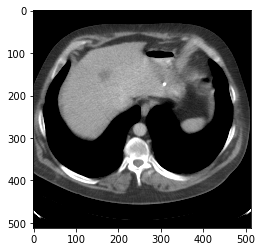

In [18]:
plt.imshow(recon_noisy[0,0,64:-64,64:-64], 'gray', vmin=args.vmin, vmax=args.vmax)

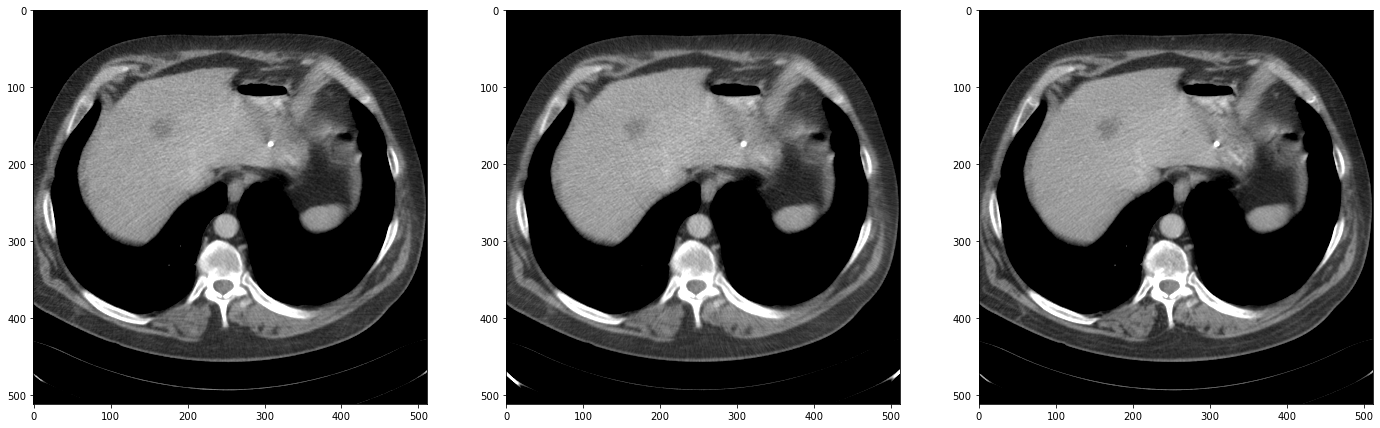

In [19]:
if showplot:
    plt.figure(figsize=[24,8])
    plt.subplot(131); plt.imshow((pred_universal + noise_level_ref / noise_level_n2n * noise_approx)[0,0,64:-64,64:-64], 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(132); plt.imshow(recon_noisy[0,0,64:-64,64:-64], 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(133); plt.imshow(ref[0,0,64:-64,64:-64], 'gray',  vmin=args.vmin, vmax=args.vmax)

In [20]:
def process(img, vmin=args.vmin, vmax=args.vmax, margin = 96):
    y = np.copy(img)
    y[y < vmin] = vmin
    y[y > vmax] = vmax
#     y = y[0,0,margin:-margin, margin:-margin]
#     y = y - scipy.ndimage.gaussian_filter(y, 5)
    
    return y

In [21]:
def cost_func(x, M, b):
    return np.mean(np.abs(M@x - b))

In [22]:
def ssim_loss(x, est_imgs, y):
    img = np.sum(est_imgs * x[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis], 0)
    img = img[0,0,...]
    y = y[0,0,...]
    
    return -calc_ssim(img, y)

In [23]:
M = np.zeros([len(est_imgs), len(est_imgs)])
b = np.zeros([len(est_imgs)])

y = process(pred_universal + noise_ratio * noise_approx)
# y = process(img.mean(0) + noise_ratio * (img.mean(0) - pred_universal))
# y = process(ref)

for k in range(len(base_imgs)):
#     if i == 0:
    fk = process(est_imgs[k])
#     else:
#         fk = process(est_imgs[k]) - process(img_approx)
    b[k] = np.sum(y * fk)
    for j in range(len(base_imgs)):
#         if j == 0:
        fj = process(est_imgs[j])
#         else:
#             fj = process(est_imgs[j]) - process(img_approx)
        M[k, j] = np.sum(fk * fj)
    
# c = np.linalg.solve(M, b)

c, _ = scipy.optimize.nnls(M, b)

# x0 = np.zeros([len(est_imgs)])
# x0[0] = 1
# c = scipy.optimize.minimize(ssim_loss, x0, (np.array([process(e) for e in est_imgs]), y))
# c = c.x

# c = np.zeros([len(est_imgs)])
# c[2] = 1

print (c)

vec = np.copy(base_imgs)
# for i in range(1,len(vec)):
#     vec[i] = vec[i] - img.mean(0)

res = np.sum(vec * c[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis], 0)

[0.41655336 0.         0.         0.         0.08756105 0.49590562]


In [24]:
# test auto blending
res_blend = pred_universal + (img.mean(0) - pred_universal) * noise_level_ref / noise_level_pred

In [25]:
# patchwise fitting
y = process(pred_universal + noise_ratio * noise_approx)
x = process(img_approx)

patchsize = [32,32]
res_p = np.zeros_like(img.mean(0))
for ix in range(20):
    for iy in range(20):
        M = np.zeros([len(est_imgs), len(est_imgs)])
        b = np.zeros([len(est_imgs)])
        
        sx = ix * patchsize[0]
        sy = iy * patchsize[1]
        
        xp = x[..., sx:sx+patchsize[0], sy:sy+patchsize[1]]
        yp = y[..., sx:sx+patchsize[0], sy:sy+patchsize[1]]
        
        for k in range(len(base_imgs)):
            fk = process(est_imgs[k][..., sx:sx+patchsize[0], sy:sy+patchsize[1]])
            b[k] = np.sum(yp * fk)
            for j in range(len(base_imgs)):
                fj = process(est_imgs[j][..., sx:sx+patchsize[0], sy:sy+patchsize[1]])
                M[k, j] = np.sum(fk * fj)
        
        if np.linalg.cond(M) < 1e10:
#             c = np.linalg.solve(M, b)
            c, _ = scipy.optimize.nnls(M, b)
        else:
            c = np.zeros([len(base_imgs)])
            c[0] = 1
        
#         print (c)
        
        res_p[..., sx:sx+patchsize[0], sy:sy+patchsize[1]] = np.sum(base_imgs[..., sx:sx+patchsize[0], sy:sy+patchsize[1]] * c[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis], 0)

In [26]:
loss_fbp = np.sqrt(np.mean((img.mean(0) - ref)[..., 96:-96,96:-96]**2))
loss_n2n = np.sqrt(np.mean((res - ref)[..., 96:-96,96:-96]**2))
loss_blend = np.sqrt(np.mean((res_blend - ref)[..., 96:-96,96:-96]**2))
loss_matched = np.sqrt(np.mean((pred_matched - ref)[..., 96:-96,96:-96]**2))
loss_universal = np.sqrt(np.mean((pred_universal - ref)[..., 96:-96,96:-96]**2))

print ('fbp:', loss_fbp)
print ('n2n:', loss_n2n)
print ('blend:', loss_blend)
print ('matched:', loss_matched)
print ('universal:', loss_universal)

fbp: 0.018819463
n2n: 0.012544881268182425
blend: 0.014949294
matched: 0.012395101
universal: 0.01147978


In [27]:
def calc_ssim(x, y, vmin=args.vmin, vmax=args.vmax):
    x = (x - vmin) / (vmax - vmin)
    x[x < 0] = 0
    x[x > 1] = 1
    
    y = (y - vmin) / (vmax - vmin)
    y[y < 0] = 0
    y[y > 1] = 1
    
    return skimage.metrics.structural_similarity(x, y, data_range = 1)

In [28]:
ssim_fbp = calc_ssim(img.mean(0)[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_n2n = calc_ssim(res[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_blend = calc_ssim(res_blend[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_matched = calc_ssim(pred_matched[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_universal = calc_ssim(pred_universal[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])

print ('fbp:', ssim_fbp)
print ('n2n:', ssim_n2n)
print ('blend:', ssim_blend)
print ('matched:', ssim_matched)
print ('universal:', ssim_universal)

fbp: 0.7807498734289727
n2n: 0.8537039860333654
blend: 0.8225681152566721
matched: 0.858431591634296
universal: 0.8636671909434005


['l2_depth_3/dose_rate_2', 'l2_depth_3/dose_rate_4', 'l2_depth_3/dose_rate_8', 'l2_depth_3/dose_rate_16', 'l2_depth_3/all']


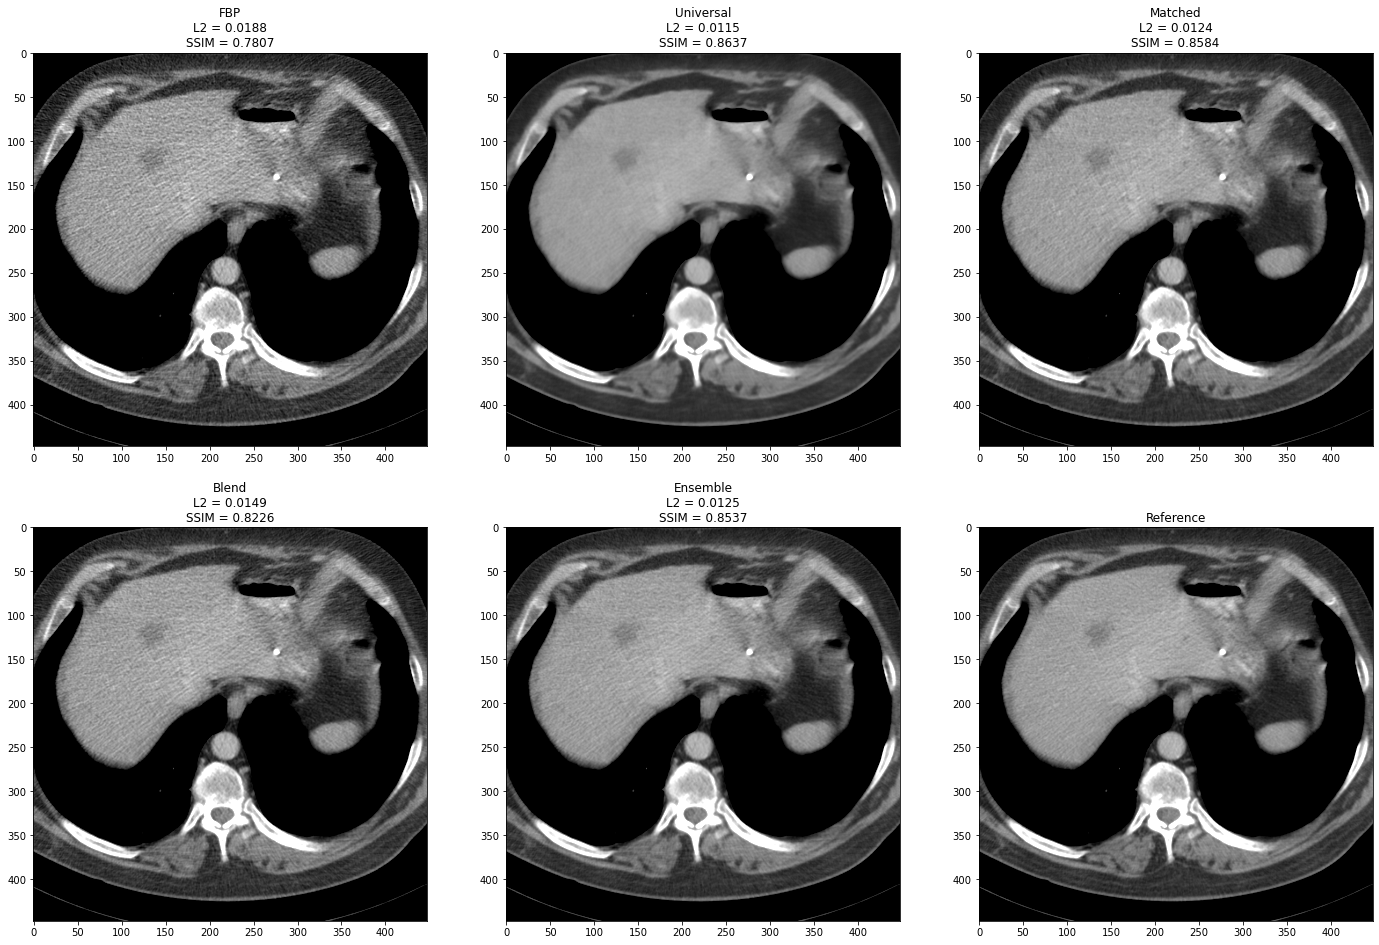

In [29]:
if showplot:
    print (tags)
    plt.figure(figsize=[24,16])
    plt.subplot(231); plt.imshow(img.mean(0)[0,0,96:-96,96:-96], 'gray', vmin=args.vmin, vmax=args.vmax); plt.title('FBP\nL2 = %.4f\nSSIM = %.4f'%(loss_fbp, ssim_fbp))
    plt.subplot(232); plt.imshow(pred_universal[0,0,96:-96,96:-96], 'gray', vmin=args.vmin, vmax=args.vmax); plt.title('Universal\nL2 = %.4f\nSSIM = %.4f'%(loss_universal, ssim_universal))
    plt.subplot(233); plt.imshow(pred_matched[0,0,96:-96,96:-96], 'gray', vmin=args.vmin, vmax=args.vmax); plt.title('Matched\nL2 = %.4f\nSSIM = %.4f'%(loss_matched, ssim_matched))
    plt.subplot(234); plt.imshow(res_blend[0,0,96:-96,96:-96], 'gray', vmin=args.vmin, vmax=args.vmax); plt.title('Blend\nL2 = %.4f\nSSIM = %.4f'%(loss_blend, ssim_blend))
    plt.subplot(235); plt.imshow(res[0,0,96:-96,96:-96], 'gray',  vmin=args.vmin, vmax=args.vmax); plt.title('Ensemble\nL2 = %.4f\nSSIM = %.4f'%(loss_n2n, ssim_n2n))
    plt.subplot(236); plt.imshow(ref[0,0,96:-96,96:-96], 'gray',  vmin=args.vmin, vmax=args.vmax); plt.title('Reference')

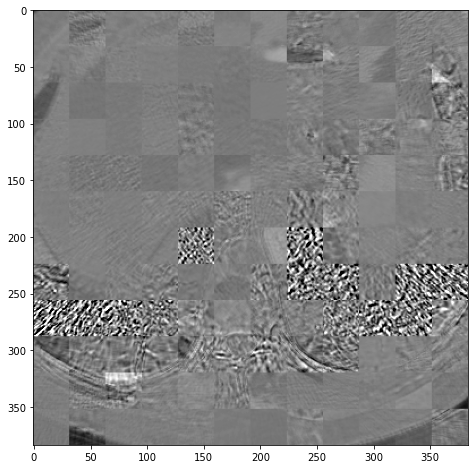

In [30]:
plt.figure(figsize=[8,8])
plt.imshow((res - res_p)[0,0,128:-128,128:-128], 'gray', vmin=-0.01, vmax=0.01)